<ipython-input-1-40d133663dac>:29: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  t = sp.arange(0.0, 100, 1/2000)
<ipython-input-1-40d133663dac>:34: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))
<ipython-input-1-40d133663dac>:38: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 4.0*sp.exp(-(V+65.0) / 18.0)
<ipython-input-1-40d133663dac>:50: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))
<ipython-input-1-40d133663dac>:54: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.125*sp.exp(-(V+65) / 80.0)
<ipython-input-1-40d133663dac>:42: DeprecationWarning: scipy.exp is deprecated and will 

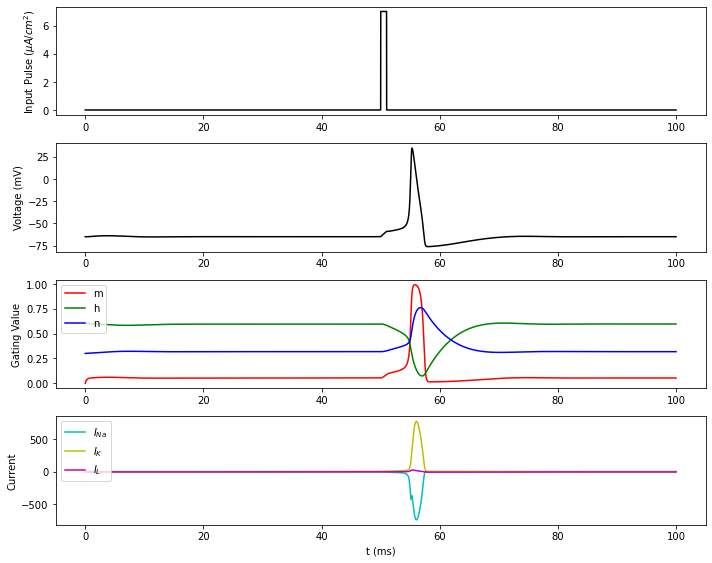

In [1]:
import scipy as sp
import pylab as plt
from scipy.integrate import odeint

class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python"""

    C_m  =   1.0
    """membrane capacitance, in uF/cm^2"""

    g_Na = 120.0 #g1
    """Sodium (Na) maximum conductances, in mS/cm^2"""

    g_K  =  36.0 #g2
    """Postassium (K) maximum conductances, in mS/cm^2"""

    g_L  =   0.3 #g3
    """Leak maximum conductances, in mS/cm^2"""

    E_Na =  50.0 # E1
    """Sodium (Na) Nernst reversal potentials, in mV"""

    E_K  = -77.0 # E2
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.4 # E3
    """Leak Nernst reversal potentials, in mV"""
    
    t = sp.arange(0.0, 100, 1/2000)
    """ The time to integrate over """

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*sp.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*sp.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + sp.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*sp.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)# E1

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)#E2
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)#E3

    def I_inj(self, t, inputPulse=50, Len_pulse=1, strength=7):
        """
        External Current

        |  :param t: time
        |  :return: step up to 7 uA/cm^2 at t>50
        |           step down to 0 uA/cm^2 at t>51
        
        """
        return strength*(t>inputPulse) - strength*(t>inputPulse+Len_pulse)

    @staticmethod
    def dALLdt(X, t, I_in, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X
        inputPulse,Len_pulse,strength = I_in
        dVdt = (self.I_inj(t,inputPulse,Len_pulse,strength) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        return dVdt, dmdt, dhdt, dndt
        
    def Main(self, Input, E0):
        """
        Main demo for the Hodgkin Huxley neuron model
        """
        X = odeint(self.dALLdt, [E0, 0, 0.6, 0.3], self.t, args=(Input, self))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)

        plt.figure(figsize = (10,8))

        
        plt.title('Hodgkin-Huxley Neuron')
        
        
        plt.subplot(4,1,1)
        #plt.ylim(-1, 20)
        i_inj_values = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj_values, 'k')
        plt.ylabel('Input Pulse ($\\mu{A}/cm^2$)')
        
        
        plt.subplot(4,1,2)
        #plt.ylim(-100, 100)
        plt.plot(self.t, V, 'k')
        plt.ylabel('Voltage (mV)')

        plt.subplot(4,1,3)
        plt.plot(self.t, m, 'r', label='m')
        plt.plot(self.t, h, 'g', label='h')
        plt.plot(self.t, n, 'b', label='n')
        plt.ylabel('Gating Value')
        plt.legend(loc = 'upper left')

        plt.subplot(4,1,4)
        plt.plot(self.t, ina, 'c', label='$I_{Na}$')
        plt.plot(self.t, ik, 'y', label='$I_{K}$')
        plt.plot(self.t, il, 'm', label='$I_{L}$')
        plt.ylabel('Current')
        plt.legend(loc = 'upper left')
        
        plt.xlabel('t (ms)')
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    runner = HodgkinHuxley()
    
    """
        Pulse Parameter
        Input

        |  :inputPulseLoc: 50
        |  :PulseLength: 1
        |  :Strength: 7
        
        E0 : -65
        """ 
    Input = [50,1,7]
    E0 = -65
    runner.Main(Input, E0)

<ipython-input-1-40d133663dac>:34: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))
<ipython-input-1-40d133663dac>:38: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 4.0*sp.exp(-(V+65.0) / 18.0)
<ipython-input-1-40d133663dac>:50: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))
<ipython-input-1-40d133663dac>:54: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.125*sp.exp(-(V+65) / 80.0)
<ipython-input-1-40d133663dac>:42: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.07*sp.exp(-(V+65.0) / 20.0)
<ipython-input-1-40d133663dac>:46: DeprecationWarning: scipy.exp is deprecated and will b

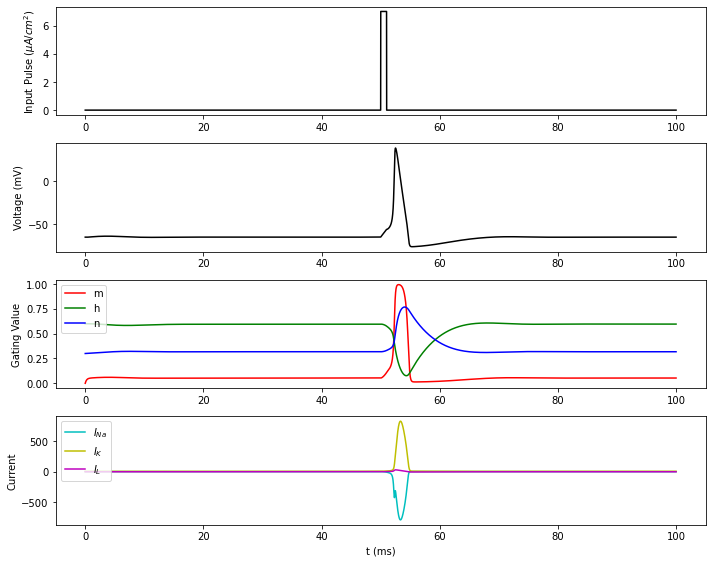

In [2]:
# set length is 10
# set intensity of the square current pulse to -65

Input = [50,1,10]
E0 = -65
runner.Main(Input, E0)

<ipython-input-1-40d133663dac>:34: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))
<ipython-input-1-40d133663dac>:38: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 4.0*sp.exp(-(V+65.0) / 18.0)
<ipython-input-1-40d133663dac>:50: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))
<ipython-input-1-40d133663dac>:54: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.125*sp.exp(-(V+65) / 80.0)
<ipython-input-1-40d133663dac>:42: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.07*sp.exp(-(V+65.0) / 20.0)
<ipython-input-1-40d133663dac>:46: DeprecationWarning: scipy.exp is deprecated and will b

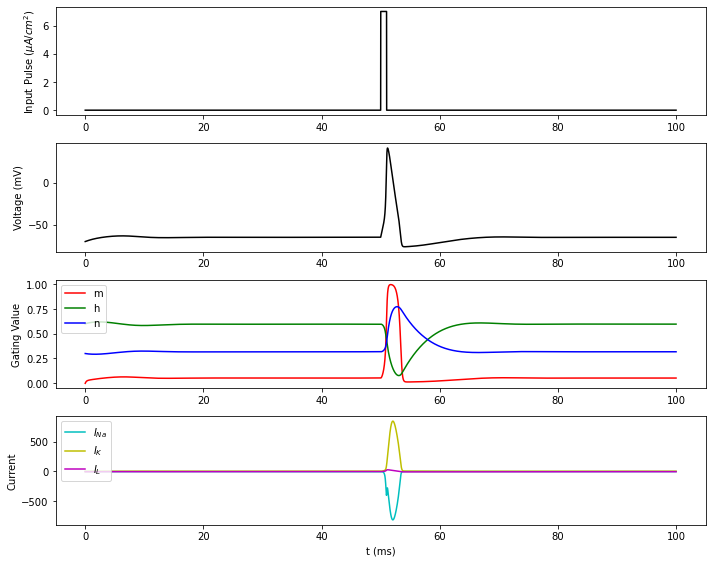

In [3]:
# set length is 35
# set intensity of the square current pulse to -70

Input = [50,1,35]
E0 = -70
runner.Main(Input, E0)